# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Imports

In [17]:
import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

import skimage
from skimage import io, measure

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score

import gc
import os
import PIL
import heapq
import graphviz
from tqdm import tqdm
from time import time
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import clear_output


SEED = 42
np.random.seed(SEED)
mpl.rc('image', cmap='gray')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Task 1: ANN (30%)

For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

## Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

In [111]:
df = pd.read_csv('Task 1.csv')

In [112]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [113]:
df.dtypes

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

In [114]:
target_cols = df.columns[-3:]
target_cols

Index(['math score', 'reading score', 'writing score'], dtype='object')

### Let's consider each column separately

#### gender

In [115]:
df['gender'].value_counts()

male      517
female    483
Name: gender, dtype: int64

We have only two classes. These two categories do not have numerical difference from each other. One-Hot Encoding will be suitable for this case.

In [116]:
gender_col = pd.get_dummies(df['gender'])
gender_col.head(3)

,female,male
0,0,1
1,1,0
2,0,1


In [117]:
df.groupby('gender')[target_cols].mean()

,math score,reading score,writing score
gender,,,
female,63.196687,71.888199,71.708075
male,69.384913,66.305609,64.029014


According to this data males are better in math but worse in reading and writing.

In [118]:
df.groupby('gender')[target_cols].mean().mean(axis=1)

gender
female    68.930987
male      66.573179
dtype: float64

The difference in average score is not very significant.

#### race/ethnicity

In [119]:
df['race/ethnicity'].value_counts()

group C    323
group D    262
group B    205
group E    131
group A     79
Name: race/ethnicity, dtype: int64

We have several classes here. These classes do not have numerical difference from each other. One-Hot Encoding will be suitable for this case.

In [120]:
race_col = pd.get_dummies(df['race/ethnicity'])
race_col.head(3)

,group A,group B,group C,group D,group E
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,0,0,1


In [121]:
df.groupby('race/ethnicity')[target_cols].mean().mean(axis=1).sort_values()

race/ethnicity
group C    64.679051
group B    65.336585
group A    66.915612
group D    71.204835
group E    72.402036
dtype: float64

#### parental level of education

In [122]:
df['parental level of education'].value_counts()

some college          222
associate's degree    203
high school           202
some high school      191
bachelor's degree     112
master's degree        70
Name: parental level of education, dtype: int64

Levels of education are qualitatively different. Having **master's degree** is significantly different from having only **school education**. Ordinal encoding will be useful here to convey the difference in levels of education.

It is a little unclear which of the levels of education is better. Difference between **associate's degree** and **some college**. I decided to look at mean values on the exams results depending on **parental level of education**.

In [123]:
avg_by_educ = df.groupby('parental level of education')[target_cols].mean().mean(axis=1).sort_values()
avg_by_educ

parental level of education
some high school      62.549738
high school           65.818482
some college          66.692192
associate's degree    70.211823
bachelor's degree     73.303571
master's degree       74.300000
dtype: float64

This order of education levels looks intuitive so I will use it for ordinal encoding.

In [124]:
educ_levels = list(avg_by_educ.index)
educ_levels

['some high school',
 'high school',
 'some college',
 "associate's degree",
 "bachelor's degree",
 "master's degree"]

In [125]:
educ_col = df['parental level of education'].apply(lambda level: educ_levels.index(level))
educ_col.head()

0    1
1    0
2    2
3    1
4    3
Name: parental level of education, dtype: int64

#### lunch

In [126]:
df['lunch'].value_counts()

standard        652
free/reduced    348
Name: lunch, dtype: int64

Ordinal encoding will be suitable here. Lunch price possibly can describe financial condition of the family.

In [127]:
lunch_col = df['lunch'].apply(lambda lunch: 1 if lunch == 'standard' else 0)
lunch_col.head(3)

0    1
1    0
2    0
Name: lunch, dtype: int64

In [128]:
df.groupby('lunch')[target_cols].mean().mean(axis=1).sort_values()

lunch
free/reduced    60.873563
standard        71.361963
dtype: float64

#### test preparation course

In [129]:
df['test preparation course'].value_counts()

none         665
completed    335
Name: test preparation course, dtype: int64

Ordinal encoding will be suitable here. **Test preparation course** can significantly influe on the exams results.

In [130]:
prep_col = df['test preparation course'].apply(lambda status: 1 if status == 'completed' else 0)
prep_col.head(3)

0    1
1    0
2    0
Name: test preparation course, dtype: int64

In [131]:
df.groupby('test preparation course')[target_cols].mean().mean(axis=1).sort_values()

test preparation course
none         65.140852
completed    72.815920
dtype: float64

### Assembling new encoded columns

In [132]:
features = pd.concat([gender_col, race_col, educ_col, lunch_col, prep_col], axis=1)
features

,female,male,group A,group B,group C,group D,group E,parental level of education,lunch,test preparation course
0,0,1,1,0,0,0,0,1,1,1
1,1,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,1,2,0,0
3,0,1,0,1,0,0,0,1,1,0
4,0,1,0,0,0,0,1,3,1,1
...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,1,0,0,1,1,0
996,0,1,0,0,0,1,0,3,0,1
997,1,0,0,0,1,0,0,0,0,0
998,1,0,0,0,1,0,0,2,1,0


### Train test split

In [133]:
is_train = np.random.choice(a=[True, False], size=(features.shape[0]), p=[0.8, 0.2])
is_train[:10]

array([ True, False,  True,  True,  True,  True,  True, False,  True,
        True])

In [134]:
is_train.sum()

801

### Data Loaders

Models learn better from standardized data.

In [135]:
x_train = features[is_train].values
x_test = features[~is_train].values

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [136]:
y_train = torch.tensor(df[target_cols][is_train].values, dtype=float)
y_test = torch.tensor(df[target_cols][~is_train].values, dtype=float)

In [137]:
batch_size = 25
num_workers = 2


train_loader = DataLoader(list(zip(x_train, y_train)),
                                batch_size=batch_size, 
                                num_workers=num_workers,
                                shuffle=True, 
                                drop_last=True)

valid_loader = DataLoader(list(zip(x_test, y_test)),
                                batch_size=batch_size, 
                                num_workers=num_workers, 
                                shuffle=False, 
                                drop_last=True)

## Fine Tuning

In [139]:
def train_model(
        model, 
        model_name,
        train_loader, 
        valid_loader,
        num_epochs=10,
        lr=0.001,
        print_res=True):
    
    model.double()
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    loaders = {"train": train_loader, "valid": valid_loader}
    losses = {"train": [], "valid": []}
    mininmum_loss = 1e9


    for epoch in tqdm(range(num_epochs)):
        for k, dataloader in loaders.items():
            epoch_loss = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                loss = criterion(outp, y_batch)

                epoch_loss += float(loss)
                epoch_all += len(outp)

                if k == "train":
                    loss.backward()
                    optimizer.step()

            losses[k].append(epoch_loss / epoch_all)

            if k == 'valid' and losses['valid'][-1] < mininmum_loss:
                torch.save(model.state_dict(), f'./models/{model_name}.pt')
                mininmum_loss = losses['valid'][-1]

    if print_res == True:
        print('\nLeast Loss:\n')
        print('train:', round(min(losses['train']), 4))
        print('test:', round(min(losses['valid']), 4))
    model.load_state_dict(torch.load(f'./models/{model_name}.pt', map_location=device))
    return losses

### One Layer model without activation

As we could see above all the features correlate with the target value linearly. The first idea is to try liner architecture without activation as a baseline solution.

In [31]:
def create_fcnn_regr(input_dim, num_outputs, hid_size=100):
    model = nn.Sequential(
        nn.Linear(input_dim, hid_size),
        nn.Linear(hid_size, num_outputs)
    )
    model.double()
    return model

In [32]:
model = create_fcnn_regr(x_train.shape[1], y_train.shape[1], hid_size=100)
losses = train_model(model, 'ann_regr', train_loader, valid_loader, num_epochs=100)

100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


Least Loss:

train: 6.365
test: 6.0219


### One Layer

We have not that many data. I decided to try one layer perceptrons. It seems that they can solve this task well.

In [34]:
def create_1l_fcnn(input_dim, num_outputs, hid_size=100):
    model = nn.Sequential(
        nn.Linear(input_dim, hid_size),
        nn.ReLU(),
        nn.BatchNorm1d(hid_size),
        nn.Linear(hid_size, num_outputs)
    )
    model.double()
    return model

In [35]:
model = create_1l_fcnn(x_train.shape[1], y_train.shape[1], hid_size=100)
losses = train_model(model, 'ann_1l_100', train_loader, valid_loader, num_epochs=30)

100%|██████████| 30/30 [00:06<00:00,  4.37it/s]


Least Loss:

train: 6.2317
test: 6.0699


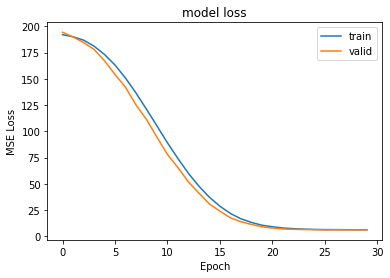

In [36]:
plt.plot(losses['train'])
plt.plot(losses['valid'])
plt.title('model loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

I will try different sizes if hidden layer.

In [49]:
grid = [4, 8, 16, 32, 64, 128]
results = {}

for hid_size in grid:
    name = f'ann_1l_{hid_size}'
    model = create_1l_fcnn(x_train.shape[1], y_train.shape[1], hid_size=hid_size)
    losses = train_model(model, name, train_loader, valid_loader, num_epochs=100, print_res=False)
    results[name] = min(losses['valid'])

100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Let's print losses of the models on the validation data.

In [50]:
results

{'ann_1l_4': 11.508801658761202,
 'ann_1l_8': 6.334617360088795,
 'ann_1l_16': 6.02811158030217,
 'ann_1l_32': 6.055213083033387,
 'ann_1l_64': 6.051569421164009,
 'ann_1l_128': 5.950027517403264}

Here I will try sigmoid instead of Relu.

In [39]:
def create_1l_fcnn_sigmoid(input_dim, num_outputs, hid_size=100):
    model = nn.Sequential(
        nn.Linear(input_dim, hid_size),
        nn.Sigmoid(),
        nn.BatchNorm1d(hid_size),
        nn.Linear(hid_size, num_outputs)
    )
    model.double()
    return model

In [44]:
grid = [4, 8, 16, 32, 64, 128]
results_sigmoid = {}

for hid_size in grid:
    name = f'ann_1l_{hid_size}'
    model = create_1l_fcnn_sigmoid(x_train.shape[1], y_train.shape[1], hid_size=hid_size)
    losses = train_model(model, name, train_loader, valid_loader, num_epochs=100, print_res=False)
    results_sigmoid[name] = min(losses['valid'])

100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


In [45]:
results_sigmoid

{'ann_1l_4': 10.89375567918,
 'ann_1l_8': 6.12539487073054,
 'ann_1l_16': 6.045346692162976,
 'ann_1l_32': 5.98353511488719,
 'ann_1l_64': 5.945554738266834,
 'ann_1l_128': 5.920992549966901}

Here I will try Hyperbolic Tangent activation function.

In [140]:
def create_1l_fcnn_tanh(input_dim, num_outputs, hid_size=100):
    model = nn.Sequential(
        nn.Linear(input_dim, hid_size),
        nn.Tanh(),
        nn.BatchNorm1d(hid_size),
        nn.Linear(hid_size, num_outputs)
    )
    model.double()
    return model

In [47]:
grid = [4, 8, 16, 32, 64, 128]
results_tanh = {}

for hid_size in grid:
    name = f'ann_1l_{hid_size}'
    model = create_1l_fcnn_tanh(x_train.shape[1], y_train.shape[1], hid_size=hid_size)
    losses = train_model(model, name, train_loader, valid_loader, num_epochs=100, print_res=False)
    results_tanh[name] = min(losses['valid'])

100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


In [48]:
results_tanh

{'ann_1l_4': 11.187610827861233,
 'ann_1l_8': 6.188163822542142,
 'ann_1l_16': 5.945359960450525,
 'ann_1l_32': 5.937719499037348,
 'ann_1l_64': 5.880323273708341,
 'ann_1l_128': 5.920990349595218}

The model with Hyperbolic Tangent activation and 64 hidden neurons showed the best result.

### Two Layer

Here I want to try to use two layer models woth tangent activattion which appeared to be the best in one layer case.

In [52]:
def create_2l_fcnn(input_dim, num_outputs, hid_size=100):
    model = nn.Sequential(
        nn.Linear(input_dim, hid_size),
        nn.Tanh(),
        nn.BatchNorm1d(hid_size),
        nn.Linear(hid_size, hid_size),
        nn.Tanh(),
        nn.BatchNorm1d(hid_size),
        nn.Linear(hid_size, num_outputs)
    )
    model.double()
    return model

In [53]:
grid = [4, 8, 16, 32, 64, 128]
results_2l = {}

for hid_size in grid:
    name = f'ann_2l_{hid_size}'
    model = create_1l_fcnn(x_train.shape[1], y_train.shape[1], hid_size=hid_size)
    losses = train_model(model, name, train_loader, valid_loader, num_epochs=100, print_res=False)
    results_2l[name] = min(losses['valid'])

100%|██████████| 100/100 [00:23<00:00,  4.35it/s]


In [54]:
results_2l

{'ann_2l_4': 11.270861386496067,
 'ann_2l_8': 6.275070936846323,
 'ann_2l_16': 6.127660817230738,
 'ann_2l_32': 6.0023350852097535,
 'ann_2l_64': 5.984034536568594,
 'ann_2l_128': 6.036452953082743}

## Conclusion

One layer model with tangent activation function and 64 hidden neurons showed the best result: **5.880323273708341**.

In [143]:
model = create_1l_fcnn_tanh(x_train.shape[1], y_train.shape[1], hid_size=64)
model.load_state_dict(torch.load('./models/ann_1l_64.pt', map_location=device))

<All keys matched successfully>

Let's now try to fine tune it with less learning rate.

In [145]:
losses = train_model(
    model, 
    'ann_1l_64_tuned.pt', 
    train_loader, 
    valid_loader, 
    num_epochs=100, 
    print_res=False,
    lr=0.0001
)

100%|██████████| 100/100 [05:10<00:00,  3.11s/it]


In [152]:
min(losses['valid'])

5.73046692162976


I got a slight improvement in quality.

Let's take a look at model's prediction.

In [157]:
with torch.no_grad():
    pred = model(torch.tensor(np.expand_dims(x_test[0], axis=0)))

pred

tensor([[50.0193, 60.8493, 59.2505]], dtype=torch.float64)

In [158]:
y_test[0]

tensor([40., 59., 55.], dtype=torch.float64)

## Questions
1. What preprocessing techniques did you use? Why?
    - We have only categorical data as input for our model. I used ordinal encoding in cases where it is meaningful and one-hot encodig otherwise.
    
    - After encoding I applied standartization to the obtained table. Optimization works better on normilized parameter space.

2. Describe the fine-tuning process and how you reached your model architecture.
    - I used MSE loss for model evaluation as we are solving regression problem.

    - I used AdamW as it trains the model faster than SGD.

    - At first I trained one layer architecture without activation as a baseline. We have good linear correlation and this model showed results comparable with more complex models.

    - Then I tried one layer ANNs with different activation functions and different hidden layer sizes.

    - The model with tanh activation showed the best result, so I tried two layer models with different hidden layers sizes. These models showed results worse than one layer ones.

    - During the learning process I used early stopping technique to save the best obtained model.

    - I added batch normalization to all the models for regularization and better training.

    - I did not used dropouts because of very simple architectures of networks.

    - In the final step I tried to learn the best model with smaller learning rate to obtain better results.

# Task 2: CNN (40%)

For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

## Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

### Image preprocessing

For preprocessing I will take an idea from my [project](https://github.com/KKroliKK/document-cropper). I will extract digits from the images by finding connected white regions.

#### Preprocessing steps

In [31]:
def show_image(image: np.ndarray):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

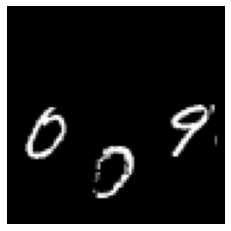

In [76]:
image = io.imread('./triple_mnist/train/009/53_009.png')
show_image(image)

After image reading I will get the mask of the image.

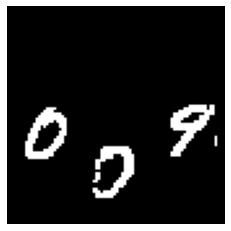

In [6]:
mask = image > np.zeros(image.shape)
show_image(mask)

Then I want to get connected white regions.

In [9]:
regions_labeled, num_regions = measure.label(mask, return_num=True)
num_regions

5

We have 5 connected white regions. The biggest 3 stand for digits, one of them comes from zero in the middle (one piece is torned off), and the 5-th region for dash near the 9 digit. I want to extract only digits regions.

In [10]:
areas = [r.filled_area for r in measure.regionprops(regions_labeled)]
digits_idxs = heapq.nlargest(3, zip(areas, range(1, num_regions + 1)))
digits_idxs = [d[1] for d in digits_idxs]
digits_idxs

[2, 1, 4]

Digits array stores indexes of the 3 biggest regions (our digits).

Indexes now correspond to all regions. Because of these indexes we now have different brightness of digits on the picture.

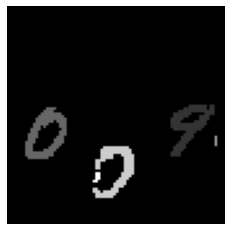

In [11]:
show_image(regions_labeled)

Now it is easy to get all 3 digits separately.

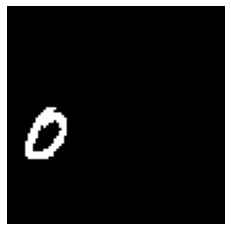

In [23]:
show_image(regions_labeled == 2)

Now I want to assign right the value of the orders of digits, indexes that exist now are shuffled.

In [19]:
digits_properties = {}
bboxes = [r.bbox for r in measure.regionprops(regions_labeled)]

for index in digits_idxs:
    bbox = bboxes[index - 1]
    index_properties = {
        'min_row': bbox[0],
        'min_col': bbox[1],
        'max_row': bbox[2],
        'max_col': bbox[3]
    }

    digits_properties[index] = index_properties

digits_properties

{2: {'min_row': 39, 'min_col': 7, 'max_row': 59, 'max_col': 23},
 1: {'min_row': 38, 'min_col': 63, 'max_row': 58, 'max_col': 80},
 4: {'min_row': 54, 'min_col': 33, 'max_row': 74, 'max_col': 49}}

We can define real order of digits by thier min_col or max col values.

In [36]:
digits_order = sorted([(properties['min_col'], idx) for idx, properties in digits_properties.items()])
digits_order = [d[1] for d in digits_order]
digits_order

[2, 4, 1]

In [53]:
digits_of_the_number = ['hundreds', 'dozens', 'ones']
digits_bounding_boxes = [digits_properties[idx] for idx in digits_order]

for d, b in zip(digits_of_the_number, digits_bounding_boxes):
    print(d + ':', b)

hundreds: {'min_row': 39, 'min_col': 7, 'max_row': 59, 'max_col': 23}
dozens: {'min_row': 54, 'min_col': 33, 'max_row': 74, 'max_col': 49}
ones: {'min_row': 38, 'min_col': 63, 'max_row': 58, 'max_col': 80}


Now digits can be cropped in needed order.

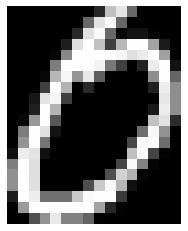

(20, 16)

In [47]:
show_image(image[39:59, 7:23])
image[39:59, 7:23].shape

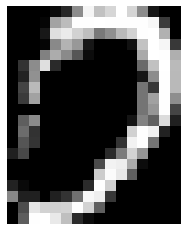

In [48]:
show_image(image[54:74, 33:49])

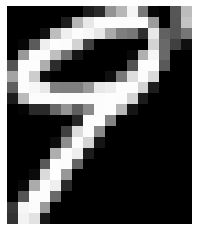

In [49]:
show_image(image[38:58, 63:80])

Also I want to add padding to cropped pictures to shape them into `(28, 28)` like in original mnist dataset.

Code for padding adding was taken from [here](https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape).

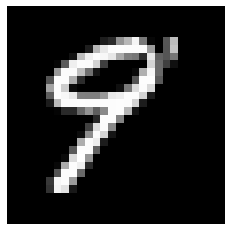

(28, 28)

In [50]:
cropped = image[38:58, 63:80]

shape = (28, 28)
result = np.zeros(shape)

# compute center offset
y_center = (shape[0] - cropped.shape[0]) // 2
x_center = (shape[1] - cropped.shape[1]) // 2

# copy img image into center of result image
result[y_center:y_center+cropped.shape[0], 
       x_center:x_center+cropped.shape[1]] = cropped

show_image(result)
result.shape

I will train my model to classify such pictures with only digit and then combine predictions from all the three digits to get triple mnist prediction.

#### Putting everything together

In [2]:
def get_mask(image: np.ndarray):
    mask = image > np.zeros(image.shape)
    return mask


def get_digits_idxs(regions_labeled: np.ndarray):
    areas = [r.filled_area for r in measure.regionprops(regions_labeled)]
    digits_idxs = heapq.nlargest(3, zip(areas, range(1, len(areas) + 1)))
    digits_idxs = [d[1] for d in digits_idxs]
    return digits_idxs


def get_digits_bounding_boxes(regions_labeled):
    digits_properties = {}
    bboxes = [r.bbox for r in measure.regionprops(regions_labeled)]

    digits_idxs = get_digits_idxs(regions_labeled)

    for index in digits_idxs:
        bbox = bboxes[index - 1]
        index_properties = {
            'min_row': bbox[0],
            'min_col': bbox[1],
            'max_row': bbox[2],
            'max_col': bbox[3]
        }

        digits_properties[index] = index_properties
    
    digits_order = sorted([(properties['min_col'], idx) for idx, properties in digits_properties.items()])
    digits_order = [d[1] for d in digits_order]

    digits_bounding_boxes = [digits_properties[idx] for idx in digits_order]

    return digits_bounding_boxes


def crop_and_padd_digit(image: np.array, bounding_box: dict, new_shape=(28, 28)):
    b = bounding_box
    cropped = image[b['min_row'] : b['max_row'], b['min_col'] : b['max_col']]

    result = np.zeros(new_shape)

    y_center = (new_shape[0] - cropped.shape[0]) // 2
    x_center = (new_shape[1] - cropped.shape[1]) // 2

    result[y_center : y_center + cropped.shape[0], 
           x_center : x_center + cropped.shape[1]] = cropped

    return result
    

In [3]:
def preprocess_image(image: np.ndarray):
    try:
        image = image.copy()
        image = skimage.color.rgb2gray(image)
    except ValueError:
        pass
    
    mask = get_mask(image)
    regions_labeled = measure.label(mask)
    digits_bounding_boxes = get_digits_bounding_boxes(regions_labeled)

    cropped_digits = [[crop_and_padd_digit(image, bounding_box)] for bounding_box in digits_bounding_boxes]
    # cropped_digits = [[crop_and_padd_digit(mask, bounding_box)] for bounding_box in digits_bounding_boxes]

    return np.array(cropped_digits)

In [90]:
preprocess_image(image).shape

(3, 1, 28, 28)

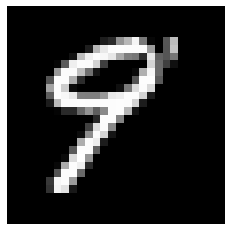

In [91]:
show_image(preprocess_image(image)[2][0])

### Data Loaders

#### Training Loaders

Let's firstly look at unchanged data.

In [4]:
dataset_train_unchanged = torchvision.datasets.ImageFolder(root='triple_mnist/train/')
dataset_valid_unchanged = torchvision.datasets.ImageFolder(root='triple_mnist/val/')
dataset_test_unchanged = torchvision.datasets.ImageFolder(root='triple_mnist/test/')

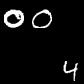

In [75]:
dataset_train_unchanged[100][0]

In [76]:
dataset_train_unchanged.classes[dataset_train_unchanged[100][1]]

'004'

Now I will apply image transformation written above. I will split each image into three ones and change labels from three digit strings into lists of three integers.

In [5]:
def split_label_train(index: int):
    label = dataset_train_unchanged.classes[index]
    digits = [int(digit) for digit in label]
    return digits


def split_label_valid(index: int):
    label = dataset_valid_unchanged.classes[index]
    digits = [int(digit) for digit in label]
    return digits


def split_label_test(index: int):
    label = dataset_test_unchanged.classes[index]
    digits = [int(digit) for digit in label]
    return digits

In [6]:
dataset_train = torchvision.datasets.ImageFolder(root='triple_mnist/train/', transform=preprocess_image, target_transform=split_label_train)
dataset_valid = torchvision.datasets.ImageFolder(root='triple_mnist/val/', transform=preprocess_image, target_transform=split_label_valid)
dataset_test = torchvision.datasets.ImageFolder(root='triple_mnist/test/', transform=preprocess_image, target_transform=split_label_test)

each feauture is now array of three images.

In [14]:
dataset_train[100][1]

[0, 0, 4]

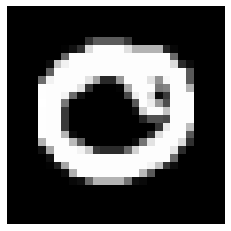

In [11]:
show_image(dataset_train[100][0][0][0])

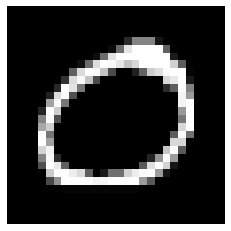

In [12]:
show_image(dataset_train[100][0][1][0])

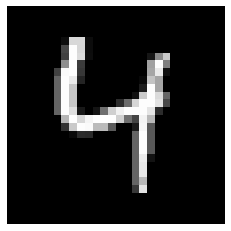

In [13]:
show_image(dataset_train[100][0][2][0])

The idea of the solution is to train a CNN to classify one digit on the picture on the images from train dataset and then evalute it's three digits prediction.

Now I will create dataloader with one digit dataset obtained from discussed preprocessing.

In [ ]:
for i in dataset_train:
    pass

There are some corrupted images such as `'triple_mnist/train/013/47_013.png'` I replaced them.

I took code from [here](https://stackoverflow.com/questions/63754311/unidentifiedimageerror-cannot-identify-image-file) to identify them and delete.

In [160]:
import os
from PIL import Image

def delete_corrupted_files(folder_path):
    extensions = []

    corrupted_files = []

    for fldr in os.listdir(folder_path):
        sub_folder_path = os.path.join(folder_path, fldr)
        for filee in os.listdir(sub_folder_path):
            file_path = os.path.join(sub_folder_path, filee)
            print('** Path: {}  **'.format(file_path), end="\r", flush=True)
            try:
                im = Image.open(file_path)
            except:
                corrupted_files.append(file_path)
            rgb_im = im.convert('RGB')
            if filee.split('.')[1] not in extensions:
                extensions.append(filee.split('.')[1])

    
    [os.remove(file) for file in corrupted_files]

In [161]:
delete_corrupted_files('triple_mnist/train')
delete_corrupted_files('triple_mnist/val')
delete_corrupted_files('triple_mnist/test')

In [7]:
def squeeze_dataset(dataset):
    '''Pushes 3-digits list into the sigle one.
    '''
    x_train, y_train = [], []

    for features, targets in dataset:
        for feature, target in zip(features, targets):
            x_train.append(feature)
            y_train.append(target)

    x_train, y_train = np.array(x_train), np.array(y_train)

    return list(zip(x_train, y_train))

This loader with shuffled digits will be used for model training.

In [8]:
batch_size = 243
num_workers = 4


train_loader = DataLoader(
    squeeze_dataset(dataset_train),
    batch_size=batch_size, 
    num_workers=num_workers,
    shuffle=True,
    drop_last=False
)

These loaders will be used for model evaluating. They are not shuffled. I will use batch size divisible by 3 to keep whole 3-digit numbers. I will use special `validate()` method to measure the accuracy of whole number prediction.

In [9]:
batch_size = 243
num_workers = 4


train_loader_for_val = DataLoader(
    squeeze_dataset(dataset_train),
    batch_size=batch_size, 
    num_workers=num_workers,
    shuffle=False, 
    drop_last=False
)

valid_loader = DataLoader(
    squeeze_dataset(dataset_valid),
    batch_size=batch_size, 
    num_workers=num_workers,
    shuffle=False, 
    drop_last=False
)

test_loader = DataLoader(
    squeeze_dataset(dataset_test),
    batch_size=batch_size, 
    num_workers=num_workers,
    shuffle=False, 
    drop_last=False
)

In [22]:
x, y = next(iter(test_loader))
y[:3]

tensor([0, 0, 2])

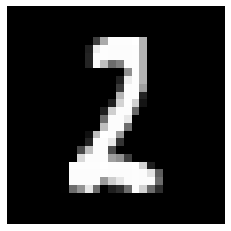

In [23]:
show_image(x[2][0])

In [10]:
def validate(dataloader, model):
    '''Computes accuracy on correctly predicted 3-digit numbers.
    '''
    model.eval()
    
    correct = 0
    number_samples = 0

    for features, labels in tqdm(dataloader):
        labels = labels.tolist()
        number_samples += len(labels) / 3

        with torch.no_grad():
            outp = model(features)
        pred = outp.argmax(-1).tolist()

        # Check wether the whole number was predicted correctly
        for i in range(0, len(pred), 3):
            correct += pred[i : i + 3] == labels[i : i + 3]

    accuracy = correct / number_samples

    return accuracy

### Training

In [52]:
def train_model(
        model,
        model_name,
        num_epochs=10,
        print_res=True):
    
    model.double()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters())

    accuracy = {"train": [], "valid": []}
    best_accuracy = 0


    for epoch in range(num_epochs):
        print('Epoch:', epoch + 1)

        for x_batch, y_batch in tqdm(train_loader, position=0, leave=True):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            model.train()
            optimizer.zero_grad()
            outp = model(x_batch)

            loss = criterion(outp, y_batch)
            loss.backward()

            optimizer.step()

        accuracy['train'].append(validate(train_loader_for_val, model))
        accuracy['valid'].append(validate(valid_loader, model))


        if accuracy['valid'][-1] > best_accuracy:
            torch.save(model.state_dict(), f'./models/{model_name}.pt')
            best_accuracy = accuracy['valid'][-1]

    if print_res == True:
        print('\nBest accuracy:\n')
        print('train:', round(max(accuracy['train']), 4))
        print('valid:', round(max(accuracy['valid']), 4))
    model.load_state_dict(torch.load(f'./models/{model_name}.pt', map_location=device))

Let's now apply best model from the previous task.

In [13]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.Tanh(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        output = self.net(x)
        return output

In [63]:
ann_model = ANN()

In [71]:
train_model(ann_model, 'ann_model', num_epochs=1)

Epoch: 1


100%|██████████| 198/198 [00:00<00:00, 206.33it/s]


Best accuracy:

train: 0.9964
valid: 0.9902


I decided to implement [LeNet architecture](https://en.wikipedia.org/wiki/LeNet) for this task for the start.

In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(400, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [76]:
model = LeNet()
model.double()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [58]:
train_model(model, 'LeNet', num_epochs=1)

Epoch: 1


100%|██████████| 198/198 [00:04<00:00, 45.81it/s]



Best accuracy:

train: 0.9958
valid: 0.991


## Conclusion

As we can see both models showed almost equal accuracy. Let's compare their indference speed.

In [14]:
device = 'cpu'

In [22]:
le_net = LeNet()
le_net.double()
le_net.load_state_dict(torch.load('./models/LeNet.pt', map_location=device))


<All keys matched successfully>

In [23]:
t = time()
validate(test_loader, le_net)
time() - t

100%|██████████| 247/247 [00:06<00:00, 36.52it/s]


6.768904447555542

In [24]:
ann = ANN()
ann.double()
ann.load_state_dict(torch.load('./models/ann_model.pt', map_location=device))

<All keys matched successfully>

In [25]:
t = time()
validate(test_loader, ann)
time() - t

100%|██████████| 247/247 [00:01<00:00, 126.12it/s]


1.963313102722168

As we can see simple ann model works more than 3 times faster than CNN model but models have almost the same number of trainable parameters.

In [26]:
sum(p.numel() for p in le_net.parameters())

60074

In [27]:
sum(p.numel() for p in ann.parameters())

51018

## Questions
1. What preprocessing techniques did you use? Why?
    - I cropped digits from each image and turned them into mnist format
2. What data augmentation techniques did you use?
    - I did not use data augmenatation because images are scaled in the same way and good reprocessing gave 99% accuracy even with very simple models. Data augmentation is needed to provide more stable and generalized predictions on test data. With my preprocessing of images I do not see suitable augmentation for this task.
3. Describe the fine-tuning process and how you reached your final CNN model.
    - I decided to try LeNet architecture it showed 99% accuracy. I cannot get better results becuase of noise in the data.

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

Let's firstly look at our data. `credit.policy` column is our target. 

As bank we are mostly interested in finding all the customers who will not pay the loan **(recall)**. But we also do not want to loose customers who will repay the loan **(precision)**.

So I will use **f1 score** as metric for this task where terget is people whom we do not want to give a loan.

In [2]:
df = pd.read_csv('loan_data.csv')
df

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


Let's take a look at our table.

In [216]:
df.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

There is no missed data in the table.

In [169]:
df.dtypes

credit.policy          int64
purpose               object
int.rate             float64
installment          float64
log.annual.inc       float64
dti                  float64
fico                   int64
days.with.cr.line    float64
revol.bal              int64
revol.util           float64
inq.last.6mths         int64
delinq.2yrs            int64
pub.rec                int64
not.fully.paid         int64
dtype: object

I need to encode `purpose column` with one-hot vectors as I can not arramge these classes. Data scaling is not needed for desicion trees.

In [3]:
purpose = pd.get_dummies(df['purpose'])
df = df.drop('purpose', axis=1)
df = pd.concat([df, purpose], axis=1)
df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,all_other,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0,1,0,0,0,0,0


Let's now look at our target column. As we can see dataset is unbalanced. Our target class is in the minority. This fact should be handled. 

In sklearn tree implementation there is a parameter `class_weight` which helps with class balancing. I will use "balanced" mode to make classes equal.

In [4]:
df['credit.policy'].value_counts()

1    7710
0    1868
Name: credit.policy, dtype: int64

I will inverse data in `credit.policy` column as my target is people who should not get the loan.

In [5]:
target = ~df['credit.policy'].astype(bool)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    df[df.columns[1:]],
    target,
    test_size=0.2,
    stratify=target,
    random_state=SEED
)

### Training

In [23]:
def score_model(tree):
    '''Count's model's metrics on test data.
    '''
    print("Best parameters set found on development set:")
    print(tree.best_params_)

    y_pred = tree.predict(x_test)
    tree_recall = recall_score(y_test, y_pred)
    tree_accuracy = accuracy_score(y_test, y_pred)
    tree_f1 = f1_score(y_test, y_pred)
    tree_precision = precision_score(y_test, y_pred)

    print('\nTest f1:', tree_f1)
    print('Test recall:', tree_recall)
    print('Precision:', tree_precision)
    print('Test accuracy:', tree_accuracy)

Let's fine tune a single tree with help of GridSearchCV.

We have unbalanced classes in our dataset, it can be handled by parameter `class_weight='balanced'`

In [16]:
param_grid = [
    {'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': list(range(4, 17, 2)),
    'min_samples_leaf': list(range(1, 6)),
    'random_state': [42],
    'class_weight': ['balanced', None],
    'ccp_alpha': [0, 0.005, 0.01, 0.015]
    }
]

tree_clf = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    cv=5,
    scoring='f1',
    param_grid=param_grid,
    n_jobs=-1,
    return_train_score=True
)

tree_clf.fit(x_train, y_train)

score_model(tree_clf)

Best parameters set found on development set:
{'ccp_alpha': 0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'random_state': 42, 'splitter': 'best'}

Test f1: 0.971736204576043
Test recall: 0.9652406417112299
Precision: 0.978319783197832
Test accuracy: 0.9890396659707724


Let's fine tune a random forest with help of GridSearchCV.

In [8]:
param_grid = [
    {'n_estimators': [3, 7, 15, 25, 50, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(6, 21, 2)),
    'min_samples_leaf': list(range(1, 6)),
    'random_state': [42],
    'class_weight': ['balanced', None],
    'ccp_alpha': [0, 0.005, 0.001],
    'n_jobs': [-1]
    }
]

forest_clf = GridSearchCV(
    estimator=RandomForestClassifier(),
    cv=5,
    scoring='f1',
    param_grid=param_grid,
    n_jobs=-1,
    return_train_score=True
)

forest_clf.fit(x_train, y_train)

score_model(forest_clf)

Best parameters set found on development set:
{'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 15, 'n_jobs': -1, 'random_state': 42}

Test f1: 0.9587912087912087
Test recall: 0.9331550802139037
Precision: 0.9858757062146892
Test accuracy: 0.9843423799582464


In [245]:
param_grid = [
    {'n_estimators': [3, 7, 15, 25, 50, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(6, 21, 2)),
    'min_samples_leaf': list(range(1, 6)),
    'random_state': [42],
    'class_weight': ['balanced', None],
    'ccp_alpha': [0, 0.005, 0.001],
    'n_jobs': [-1]
    }
]

forest_clf = GridSearchCV(
    estimator=RandomForestClassifier(),
    cv=5,
    scoring='recall',
    param_grid=param_grid,
    n_jobs=-1,
    return_train_score=True
)

forest_clf.fit(x_train, y_train)

score_model(forest_clf)

Best parameters set found on development set:
{'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 2, 'n_estimators': 3, 'n_jobs': -1, 'random_state': 42}

Test recall: 0.9572192513368984
Precision: 0.9347258485639687
Test f1: 0.9458388375165125
Test accuracy: 0.9786012526096033


### Analysis

In [13]:
df.columns[0]

'credit.policy'

In my implementation people whom we can give a loan have `lable 0` and those whom we should not have `lable 1`.

In [20]:
def plot_tree(clf):
    dot_data = tree.export_graphviz(clf, out_file=None,
                       feature_names=df.columns[1:],
                       class_names=['give', 'not give'],
                       filled=True, rounded=True,
                       special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

Let's plot single tree.

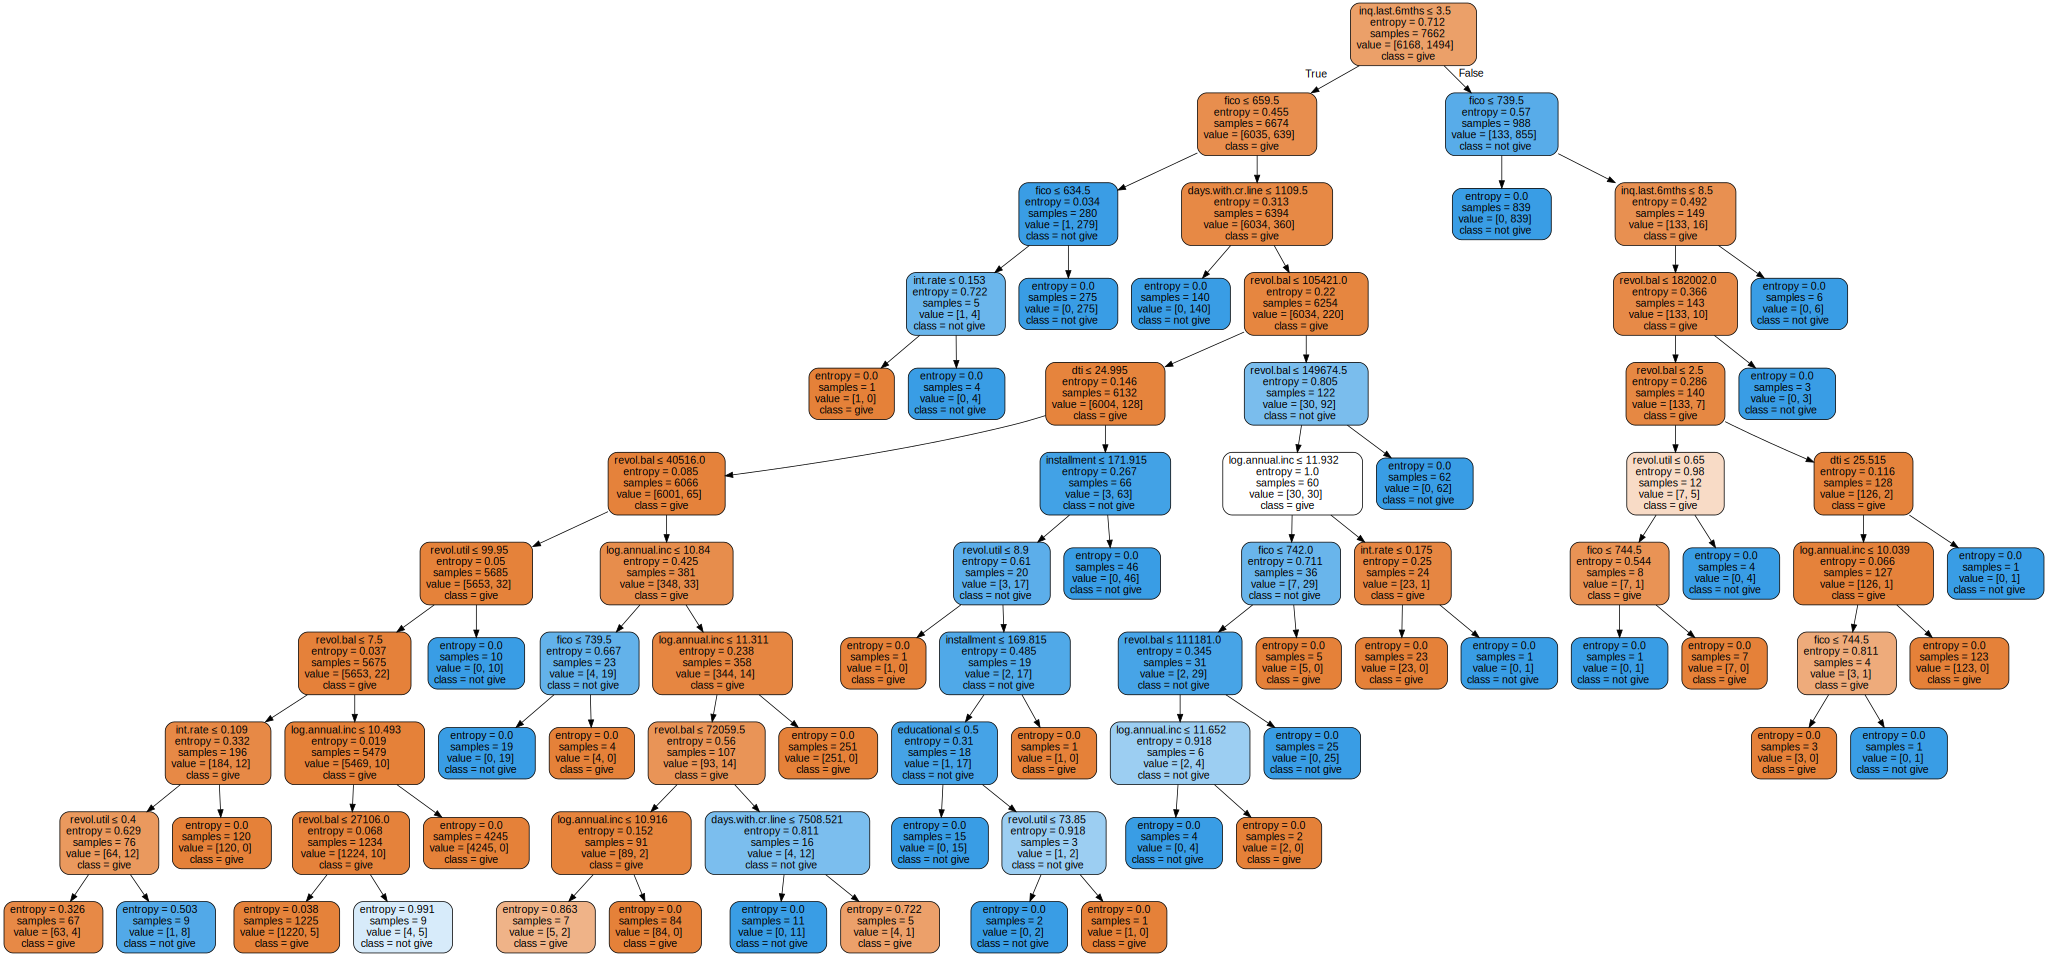

In [21]:
plot_tree(tree_clf.best_estimator_)

Let's now plot one of the trees from the forest.

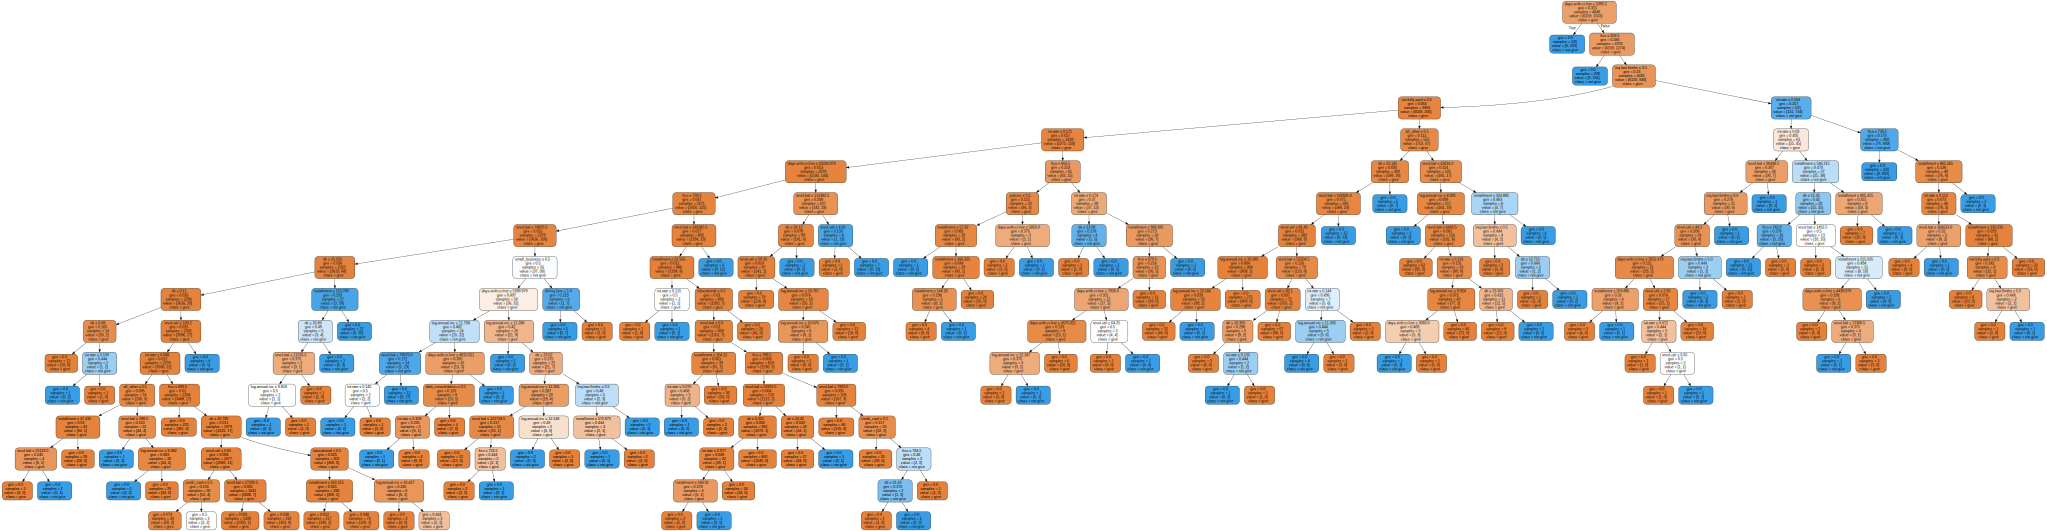

In [22]:
plot_tree(forest_clf.best_estimator_.estimators_[0])

### Questions
1. How did the DT compare to the RF in performance? Why?
    - I have chosen `f1 score` as a key metric for this task and applied grid search to find a tree and a forest which give the best performance in this metric. I have **0.972** for DT and **0.959** for the RF.
    - As we can see DT shows better performance in comparison to RF. It seems strange at first glance. I think I have got such results because of nature of our data. The main problem of decision trees is that they are easily overfitted. It is really a problem if data is noisy then single tree learns this noise and then badly perform on test data. That is why we usually want to try to use RF istead of DT. But in our case I think we have very clean data, so clean that a single tree gives **accuracy 0.989** on test data. If it is the case that tere is no noise in data then DT will learn pure dependency in the data. RF trees are learned on incomplete set of data, so they can not observe the 'full picture'. Each of them becomes underfitted and their common prediction is a little bit worse than DT's one because this tree is fitted perfectly.
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - After fine-tuning DT has max depth 10 and RF has max depth equal to 16.
    - By changing max depth of the decision tree we can vary bias and variance of the model. Deep tree has smaller bias but bigger variance. Small tree has bigger bias and smaller variance.
    - While training random forest we use deep trees with small bias and big variance and then we decrease their variance by averaging trees' predictions. The single tree should find bias variance trade-off optimal point in it's own architecture with medium bias and medium variance.
3. What is ensemble learning? What are its pros and cons?
    - In ensemble learning with use several models instead of one to solve the task. We can **reduce variance of complex models** without increase of bias and we can **reduce bias of simple models** without increase in variance. 
    - The advantages of ensemble learning are that such complex models work better on average than single ones.
    - Еhe disadvantages are that it is more difficult for us to train such ensembled models. Their architecture is harder, they need more computational resources and time especially when the ensemble learning process cannot be parallelized.
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - **AdaBoost**: This algorithm starts with building of solution with the same weights for all points and then iteratively increases weight of the mistakes and builts new solutions until the needed accuracy os achieved. Finally, we combine obtained solutions to get ensemble predictions.
    - **Gradient Boosting**: uses small dicizion trees as weak learners. Trees are learned and added one by one, each new tree minimizes mistake of all it's ancestors.
    - **Bagging Meta-Estimator**: we learn strong models with high variance on small subsets of data and then use some meta-model to combine their results into prediction.
    - **Random Forest**: we learn models on bootstrapped samples and then just average their results to get the prediction. We choose trees as the basic model here. They are complex and can learn train data to 0 error. Averaging of their predictions saves us from overfitting.

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

There are a lot of images with wrong targets. I corrected them by hands.

In [89]:
from skimage.color import rgb2gray
from skimage.filters import threshold_local, gaussian, rank, threshold_minimum
from skimage.morphology import disk, binary_closing
from skimage import color, measure
from skimage.util import img_as_ubyte
from skimage.transform import rescale, resize, downscale_local_mean
from torch.nn.functional import softmax

In [29]:
rootdir = 'svhn'
svhn = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        label = os.path.join(subdir, file)[5:8]
        image = io.imread(os.path.join(subdir, file))
        svhn.append((image, label))

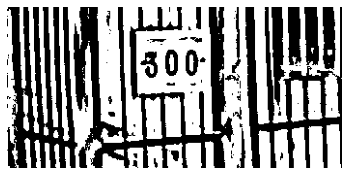

In [32]:
image = svhn[0][0]

def apply_thresholding(image):
    gray = rgb2gray(image)
    # gray = gaussian(gray, 2)
    gray = img_as_ubyte(gray)
    local_otsu = rank.otsu(gray, disk(8))
    mask = gray >= local_otsu

    return mask


show_image(apply_thresholding(image))

In [63]:
def show_images(image):
    became = apply_thresholding(image)

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    axes[0].imshow(image)
    axes[0].set_title('Original')

    axes[1].imshow(became)
    axes[1].set_title('After Transformation')

    for a in axes.ravel():
        a.axis('off')
    
    plt.show()


I need to preprocess images before giving them into the model. At first, I will apply otsu thresholding then I will feed obtained white regions to the model and comapare their softmax values. For background pieces it is more likely to get lower softmax values than for digits on the picture. I will take three regions with the highest softamax values as digits and take them as prediction.

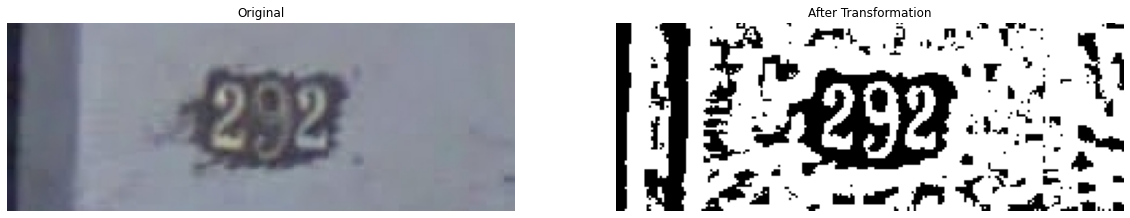

In [72]:
show_images(svhn[6][0])

In [33]:
image = svhn[6][0]
mask = apply_thresholding(image)
regions_labeled, num_regions = measure.label(mask, return_num=True)

I will try to distinguish between background regions and digit regions

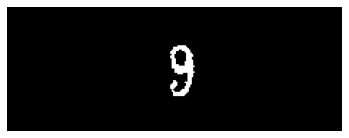

In [45]:
show_image(regions_labeled == 8)

In [50]:
region = (regions_labeled == 1)

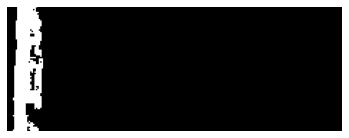

In [38]:
show_image(regions_labeled == 1)

In [54]:
def get_digits_bounding_boxes(regions_labeled):
    digits_properties = {}
    bboxes = [r.bbox for r in measure.regionprops(regions_labeled)]

    for i, bbox in enumerate(bboxes):
        index_properties = {
            'min_row': bbox[0],
            'min_col': bbox[1],
            'max_row': bbox[2],
            'max_col': bbox[3]
        }

        digits_properties[i] = index_properties
    
    # sort regions from left to the right
    digits_order = sorted([(properties['min_col'], idx) for idx, properties in digits_properties.items()])
    digits_order = [d[1] for d in digits_order]

    digits_bounding_boxes = [digits_properties[idx] for idx in digits_order]

    return digits_bounding_boxes

In [57]:
bboxes = get_digits_bounding_boxes(regions_labeled)
bboxes

[{'min_row': 0, 'min_col': 4, 'max_row': 86, 'max_col': 25},
 {'min_row': 75, 'min_col': 19, 'max_row': 82, 'max_col': 22},
 {'min_row': 7, 'min_col': 23, 'max_row': 8, 'max_col': 24},
 {'min_row': 0, 'min_col': 30, 'max_row': 86, 'max_col': 232},
 {'min_row': 83, 'min_col': 43, 'max_row': 84, 'max_col': 45},
 {'min_row': 22, 'min_col': 52, 'max_row': 23, 'max_col': 53},
 {'min_row': 0, 'min_col': 56, 'max_row': 2, 'max_col': 58},
 {'min_row': 77, 'min_col': 68, 'max_row': 78, 'max_col': 69},
 {'min_row': 28, 'min_col': 94, 'max_row': 58, 'max_col': 109},
 {'min_row': 27, 'min_col': 113, 'max_row': 62, 'max_col': 130},
 {'min_row': 29, 'min_col': 132, 'max_row': 58, 'max_col': 146},
 {'min_row': 84, 'min_col': 168, 'max_row': 85, 'max_col': 169},
 {'min_row': 0, 'min_col': 185, 'max_row': 1, 'max_col': 186},
 {'min_row': 85, 'min_col': 191, 'max_row': 86, 'max_col': 192},
 {'min_row': 85, 'min_col': 193, 'max_row': 86, 'max_col': 194},
 {'min_row': 0, 'min_col': 228, 'max_row': 1, 'max

In [69]:
def crop_image(image: np.array, bounding_box: dict, new_shape=(28, 28)):
    b = bounding_box
    cropped = image[b['min_row'] : b['max_row'], b['min_col'] : b['max_col']]

    return cropped
    

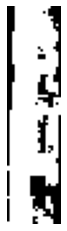

In [70]:
cropped = crop_image(mask, bboxes[0])
show_image(cropped)

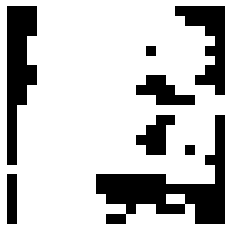

In [66]:
image_resized = resize(
    cropped, 
    (22, 22)
)

show_image(image_resized)

In [148]:
def get_white_area(image):
    return image.sum() / (image.shape[0] * image.shape[0])

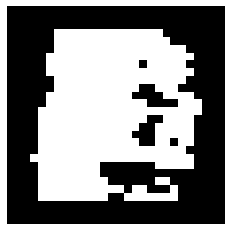

In [68]:
def add_padding(resized, new_shape=(28, 28)):
    result = np.zeros(new_shape)

    y_center = (new_shape[0] - resized.shape[0]) // 2
    x_center = (new_shape[1] - resized.shape[1]) // 2

    result[y_center : y_center + resized.shape[0], 
            x_center : x_center + resized.shape[1]] = resized

    return result

show_image(add_padding(image_resized))

In [149]:
def preprocess_svhn(image):
    mask = apply_thresholding(image)
    regions_labeled, num_regions = measure.label(mask, return_num=True)

    bboxes = get_digits_bounding_boxes(regions_labeled)

    segments = []

    for bbox in bboxes:
        cropped = crop_image(mask, bbox)
        image_resized = resize(cropped, (20, 20))
        
        # filter non-digit regions by number of 
        # white pixels
        square = get_white_area(image_resized)
        if square < 0.5 or square > 0.63:
            continue

        padded = add_padding(image_resized)
        segments.append(padded)
        # segments.append(image_resized)

    return segments
    
regions = preprocess_svhn(image)

After preprocessing we get list of such image. Obtained pictures are very similar to MNIST dataset format on which model was trained on. Now we should differ them from other regions.

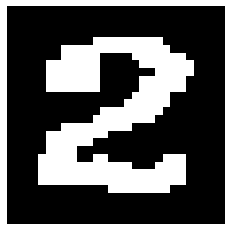

In [141]:
show_image(regions[0])

In [40]:
le_net = LeNet()
le_net.load_state_dict(torch.load('./models/LeNet.pt', map_location=device))

<All keys matched successfully>

In [101]:
def get_proba(region):
    with torch.no_grad():
        outp = le_net(torch.tensor(np.expand_dims(region, axis=0)))
    prob = softmax(outp, dim=1)
    pred = int(prob.argmax(-1))

    prob = float(prob[0][pred])

    return prob, pred

For real region with 2 I get softmax equal to almost 1

In [142]:
get_proba(regions[1])

(0.9988603346904972, 9)

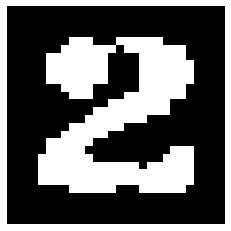

In [143]:
show_image(regions[2])

I had problem here. Model is very confident in predicting digits from regions without digits. So I tuned area filtering to keep only digits regions for this example. In the common case I will try to peek the most confident three regions and return the result.

In [128]:
get_proba(regions[0])

(0.9987567107449971, 4)

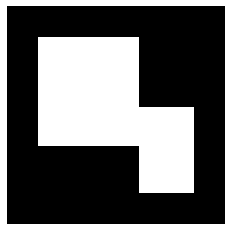

In [129]:
show_image(regions[0])

I will predict values and probabilities for all the regions and take predictions with the biggest confidence.

In [177]:
def predict_svhn(image):
    regions = preprocess_svhn(image)
    predictions = [get_proba(region) for region in regions]

    probas = [pred[0] for pred in predictions]
    labels = [pred[1] for pred in predictions]

    # digits_idxs = heapq.nlargest(3, zip(probas, range(len(probas))))
    digits_idxs = sorted(zip(probas, range(len(probas))))
    digits_idxs = [d[1] for d in digits_idxs]
    digits_idxs = sorted(digits_idxs)

    try:
        prediction = [labels[digits_idxs[0]], labels[digits_idxs[1]], labels[digits_idxs[2]]]
        return ''.join(str(l) for l in prediction)
    except IndexError: # if region filtering left less tha 3 regions
        return -1

In [173]:
predict_svhn(image)

'292'

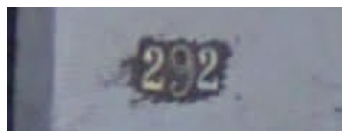

In [168]:
show_image(image)

## Testing

In [178]:
sum = 0

for picture, label in svhn:
    prediction = predict_svhn(picture)
    sum += prediction == label

sum / len(svhn)

0.011111111111111112

In [179]:
sum

1

### Questions
1. How did your model perform? Why is it better/worse?
    - My model did not work in this task. Model was trained tp classify ideal black and white photos with digits in the center. It expects this format as input. SVHN dataset has very complex rgb pictures with a lot of errosions, different size, different angles of view. I tried to come up with suitable image prerocessing but my preprocessing does not work properly.
2. What is domain gap in the context of ML?
    - Domain gap is difference in data that we need to handle if we want to reuse our model on some way different data in comparison to data model was trained on.
3. Suggest two ways through which the problem of domain gap can be tackled.
    - We can fine tune our model to perform on the new task. As exapmle. If we have not a very big dataset of bees and wasps and we want to classify them we can take model trained on ImageNet then change it's classification head and possibly unfreeze lower convolutional layers. Such tuned model will work well on this task.
    - We can try to apply transformations to the new data as I tried to perform in this task. If new data will be converted to the format of data the model was trained on the model will perform well.